In [404]:
from collections import deque
from logging import setLogRecordFactory


class FixedSizeQueue:
    def __init__(self, max_length):
        self.queue = deque([0] * max_length, maxlen=max_length)

    def enqueue(self, item):
        self.queue.append(item)

    def get_average(self):
        return sum(self.queue) / len(self.queue)

    def get_last(self):
        return self.queue[-1]

    def __str__(self):
        return str(list(self.queue))

In [405]:
class Creature:
    def __init__(self):
        self.ticks_per_second = 20
        self.time_resolution = 1 / self.ticks_per_second
        self.mass = 1
        self.gravity = 9.81
        self.friction_coefficient = 0.1
        self.f_friction = self.friction_coefficient * self.mass * self.gravity
        self.battery = 100
        self.velocity_history = FixedSizeQueue(100)

    def get_data(self):
        return self.battery, self.velocity_history.get_last(), self.velocity_history.get_average()

    def battery_discharge(self, x: float):
        """Given a certain requested force, by how much to lower the battery"""
        return (x / 5) ** 2

    def apply_force(self, force: float) -> None:
        self.battery = min(self.battery + 1, 100)
        battery_to_discharge = self.battery_discharge(abs(force))
        if battery_to_discharge <= self.battery:
            v_old = self.velocity_history.get_last()
            friction = -self.f_friction if (v_old > 0) else (self.f_friction if v_old < 0 else 0)
            f_net = force + friction
            """ friction acts opposite current velocity """
            friction_deceleration = True if abs(force) < self.f_friction else False
            """ is the object decelerating due to friction and not applied force? if so then it naturally slows to a halt as the force is weaker then friction, it will not move the other way """
            delta_v = (f_net * self.time_resolution) / self.mass
            v_new = v_old + delta_v
            v_new = 0 if (friction_deceleration and v_new * v_old < 0) else v_new
            """ checks if v_old to v_new has made a switch from pos to neg or vice versa; if decelerating due to friction, then v_new must be 0 as stated above """
            self.velocity_history.enqueue(v_new)
            self.battery -= battery_to_discharge
        else:
            self.velocity_history.enqueue(0)

In [406]:
import torch
from torch import nn


class Model(nn.Module):
    def __init__(self, latent_size: int, num_inputs: int) -> None:
        super().__init__()

        self.latent_space = torch.zeros(latent_size)
        self.predicted_latent_space = torch.zeros(latent_size)
        self.prev_force = torch.zeros(1)

        self.layer_norm = nn.LayerNorm(latent_size)

        self.mean_history = []
        self.std_history = []

        self.encoder = nn.Sequential(
            nn.Linear(latent_size + num_inputs, latent_size),
            nn.LeakyReLU(),
            nn.Linear(latent_size, latent_size),
        )

        self.mean = nn.Sequential(
            nn.Linear(latent_size, 10),
            nn.LeakyReLU(),
            nn.Linear(10, 1)
        )
        self.std = nn.Sequential(
            nn.Linear(latent_size, 10),
            nn.LeakyReLU(),
            nn.Linear(10, 1),
            nn.Softplus()
        )

        self.predictor = nn.Sequential(
            nn.Linear(latent_size + 1, latent_size),
            nn.LeakyReLU(),
            nn.Linear(latent_size, latent_size),
        )

    def forward(self, inputs):
        residual = self.encoder(torch.cat([inputs, self.latent_space], dim=0))
        curr_lat_space = residual + self.latent_space
        curr_lat_space = self.layer_norm(curr_lat_space)

        mean = self.mean(curr_lat_space)
        std = self.std(curr_lat_space)

        self.mean_history.append(mean.item())
        self.std_history.append(std.item())

        temp = torch.cat([self.latent_space, self.prev_force], dim=0)
        predicted = self.predictor(temp) + self.latent_space
        predicted = self.layer_norm(predicted)

        dist = torch.distributions.Normal(mean, std)
        y = dist.rsample()
        y = torch.clamp(y, min=mean - 3 * std, max=mean + 3 * std)

        self.prev_force = y.detach()
        self.latent_space = curr_lat_space.detach()
        self.predicted_latent_space = predicted

        return y, std

In [407]:
import torch
from torch import nn


class RewardFunction(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.a = 1
        self.v = 1
        self.s = 1
        self.eps = 1e-5

    def forward(self, real_latent, predicted_latent, velocity_reward, standard_deviation):
        uncertainty_scaling = 1 / (standard_deviation * self.a + self.eps)

        euclid_dist = torch.cdist(real_latent, predicted_latent)
        surprise_factor = euclid_dist * self.s * uncertainty_scaling
        weighted_velocity_reward = velocity_reward * self.v

        composite_reward = weighted_velocity_reward - surprise_factor

        return torch.exp(-composite_reward)

In [408]:
TIMESTEPS = 1000000
LEARNING_RATE = 0.001

robot = Creature()
model = Model(
    latent_size=32,
    num_inputs=3,
)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
reward_fn = RewardFunction()

velocity_hist = []
avg_velocity_hist = []
battery_hist = []
loss_history = []

model.train()

for timestep in range(TIMESTEPS):
    optimizer.zero_grad()

    battery, v_last, v_average = robot.get_data()

    data = torch.Tensor([battery / 100, v_last, v_average])

    y1, stdev = model(data)

    robot.apply_force(y1.item())
    v_curr = robot.velocity_history.get_last()
    v_avg = robot.velocity_history.get_average()

    velocity_hist.append(v_curr)
    avg_velocity_hist.append(v_avg)
    battery_hist.append(robot.battery)

    loss = reward_fn(
        real_latent=model.latent_space.unsqueeze(0),
        predicted_latent=model.predicted_latent_space.unsqueeze(0),
        velocity_reward=v_curr,
        standard_deviation=stdev.item(),
    )

    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    loss_history.append(loss.item())

    if (timestep + 1) % 100 == 0:
        print(f"T {timestep + 1:,} - {((timestep + 1) / TIMESTEPS) * 100:.2f}%", end=" ")
        print(f"| V {v_curr:.5f}", end=" ")
        print(f"| AV {v_avg:.5f}", end=" ")
        print(f"| L {loss.item():.4f}", end="\n")

T 100 - 0.01% | V -0.01810 | AV -0.01896 | L 1.0773
T 200 - 0.02% | V -0.04072 | AV -0.02718 | L 1.0921
T 300 - 0.03% | V 0.00000 | AV -0.03755 | L 1.0299
T 400 - 0.04% | V -0.05031 | AV -0.03618 | L 1.0871
T 500 - 0.05% | V 0.00000 | AV -0.04194 | L 1.0242
T 600 - 0.06% | V -0.05096 | AV -0.03096 | L 1.0949
T 700 - 0.07% | V 0.00000 | AV -0.02463 | L 1.0413
T 800 - 0.08% | V -0.00698 | AV -0.03383 | L 1.0794
T 900 - 0.09% | V 0.00000 | AV -0.03576 | L 1.0581
T 1,000 - 0.10% | V -0.03531 | AV -0.03483 | L 1.0932
T 1,100 - 0.11% | V -0.02677 | AV -0.03675 | L 1.0906
T 1,200 - 0.12% | V -0.04212 | AV -0.02386 | L 1.1047
T 1,300 - 0.13% | V 0.00000 | AV -0.02793 | L 1.0588
T 1,400 - 0.14% | V -0.04044 | AV -0.03310 | L 1.1104
T 1,500 - 0.15% | V -0.03302 | AV -0.02665 | L 1.0946
T 1,600 - 0.16% | V 0.00000 | AV -0.03005 | L 1.0518
T 1,700 - 0.17% | V -0.05195 | AV -0.02156 | L 1.1224
T 1,800 - 0.18% | V -0.01811 | AV -0.03014 | L 1.0763
T 1,900 - 0.19% | V 0.00000 | AV -0.02705 | L 1.0436

KeyboardInterrupt: 

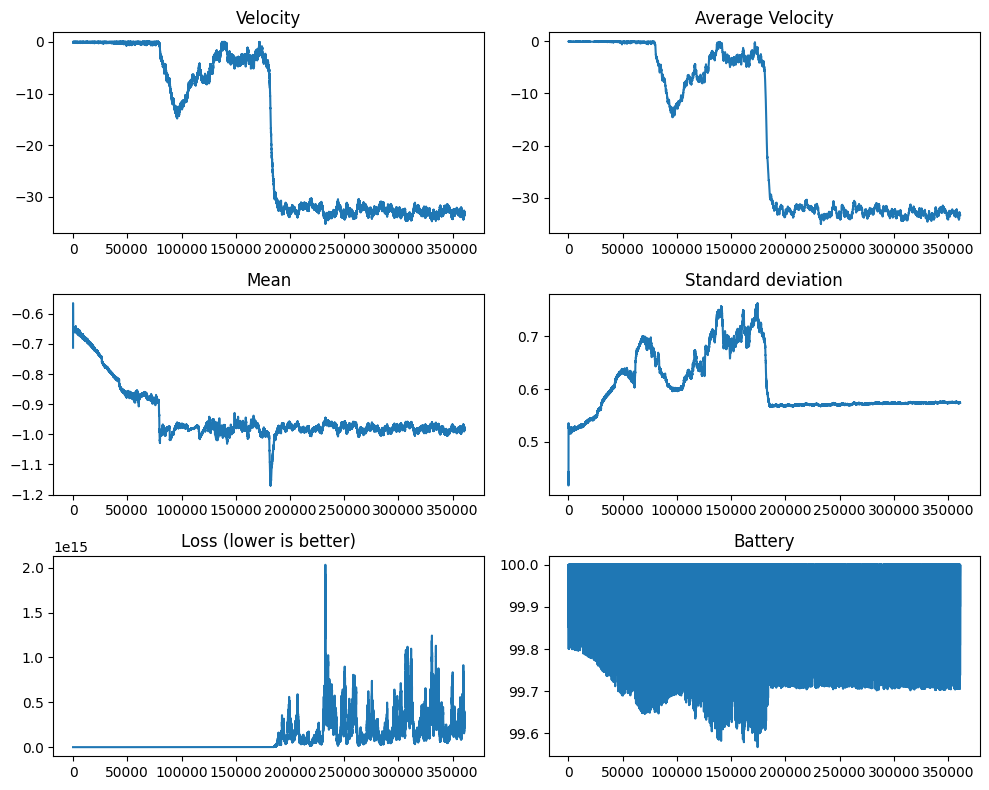

In [409]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(3, 2, figsize=(10, 8))

axes = axes.flatten()

axes[0].plot(velocity_hist)
axes[0].set_title('Velocity')

axes[1].plot(avg_velocity_hist)
axes[1].set_title('Average Velocity')

axes[2].plot(model.mean_history)
axes[2].set_title('Mean')

axes[3].plot(model.std_history)
axes[3].set_title('Standard deviation')

axes[4].plot(loss_history)
axes[4].set_title('Loss (lower is better)')

axes[5].plot(battery_hist)
axes[5].set_title('Battery')

plt.tight_layout()

plt.show()